In [92]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import imageio
from wordcloud import WordCloud , STOPWORDS
from collections import Counter
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.layers import (Embedding , GRU, Dense , Concatenate)
from PIL import Image

In [2]:
Path = "flickr8k/Images/"
all_imgs_id = []
all_captions = []
all_imgs_path = []

with open("flickr8k/captions.txt",'r') as file:
    next(file)
    for line in file:
        split_arr = line.split(",")
        all_imgs_id.append(split_arr[0])
        all_captions.append(split_arr[1].strip("\n"))
        all_imgs_path.append(Path+split_arr[0])


In [3]:
df = pd.DataFrame(list(zip(all_imgs_id , all_imgs_path ,all_captions )) , columns = ["ID" , "Path" , "Caption"])

In [4]:
df.head()

,ID,Path,Caption
0,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


flickr8k/Images/1024138940_f1fefbdce1.jpg
flickr8k/Images/1015584366_dfcec3c85a.jpg
flickr8k/Images/1015118661_980735411b.jpg
flickr8k/Images/1026685415_0431cbf574.jpg
flickr8k/Images/1053804096_ad278b25f1.jpg


C:\Users\DELL\AppData\Local\Temp\ipykernel_1792\3619730920.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imageio.imread(img))


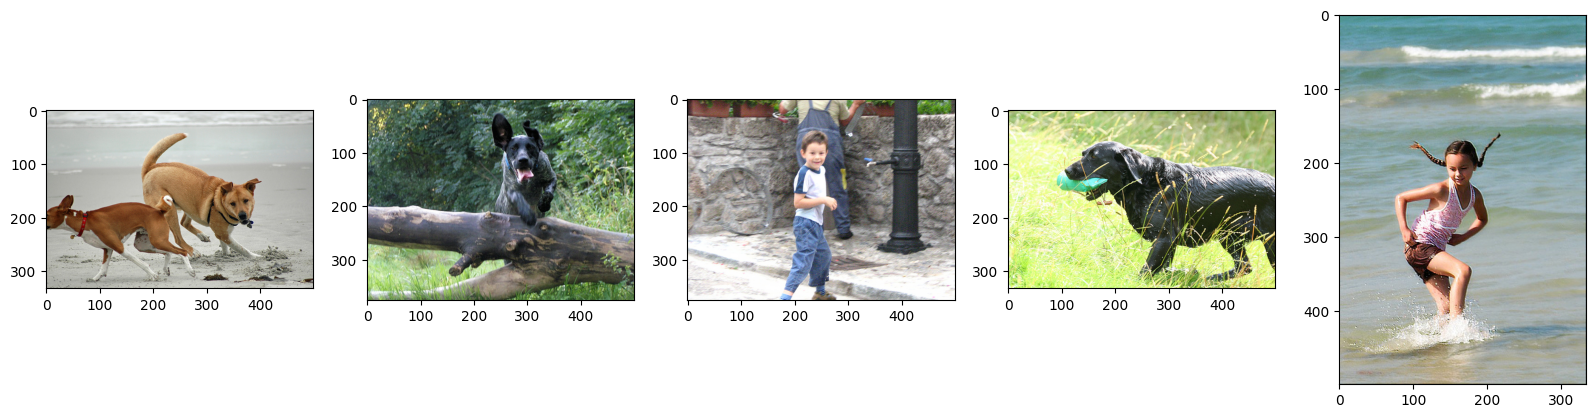

In [5]:
figure , axes = plt.subplots(1,5)
figure.set_figwidth(20)

def plot_random():
    for i , ax in zip(range(5),axes):
        random_n = random.randrange(20,200,5)
        img = all_imgs_path[random_n]
        print(img)
        ax.imshow(imageio.imread(img))

plot_random()

C:\Users\DELL\AppData\Local\Temp\ipykernel_1792\2360625224.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


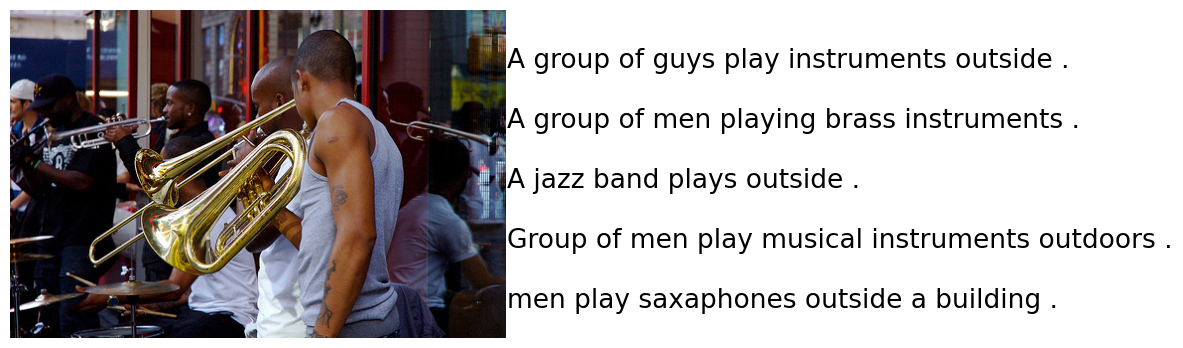

In [6]:
def image_with_caption(df):
    img_path = df.sample()["Path"].to_list()[0]
    condition = df["Path"] == img_path
    captions = df[condition]["Caption"].to_list()
    captions = ("\n"*2).join(captions)
    img = imageio.imread(img_path)
    figure , ax = plt.subplots()
    ax.set_axis_off()
    w , h = img.shape[0] , img.shape[1]
    ax.imshow(img)
    ax.text(w+170 , h -200, captions , fontsize=19 )


image_with_caption(df)

In [7]:
vocabulary = [word.lower() for caption in all_captions for word in caption.split()]

voc_count = Counter(vocabulary)

<Axes: xlabel='Word'>

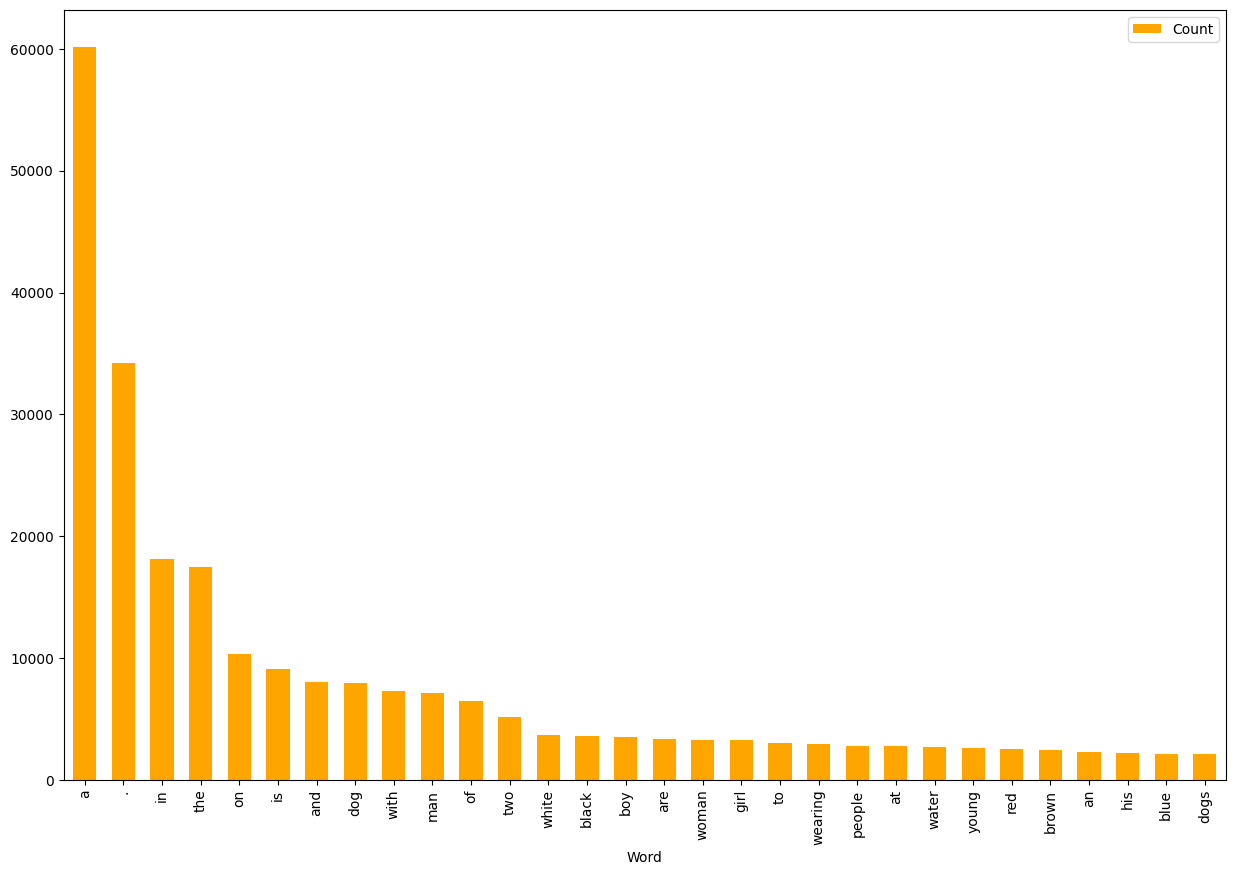

In [8]:
mc = voc_count.most_common(30)
most_common_word_df = pd.DataFrame(mc , columns=["Word", "Count"])
most_common_word_df.plot.bar(x="Word" , y="Count" , width = 0.6 , color="orange" , figsize=(15, 10))

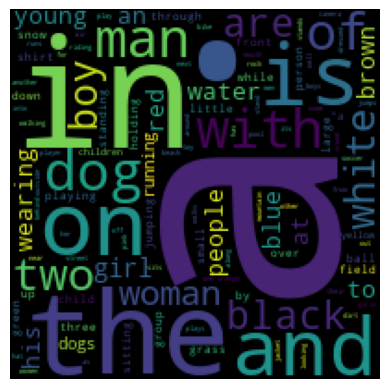

In [9]:
wordcloud = WordCloud(width=200 , height=200).generate_from_frequencies(voc_count)
plt.imshow(wordcloud)
plt.axis("off");

## Data PreProcessing

In [10]:
# pd.set_option()
df["Caption"].sample(6)

16270    A puppy sniffs a human foot that is resting on...
39016                   A child is splashing in the surf .
10647    "A man walks under a bridge and reads grafitti...
7168     A man is skiing down a snowy hill while he cas...
17303    A dog jumping over a gate followed by another ...
20448    A skateboarder performing a kickflip over shor...
Name: Caption, dtype: object

In [11]:
rem_punct = str.maketrans("" , "" , string.punctuation)

In [12]:
for r in range(len(all_captions)) :
  line = all_captions[r]
  line = line.split()
  
  line = [word.lower() for word in line]
  
  line = [word.translate(rem_punct) for word in line]
  line = [word for word in line if len(word) > 1]

  
  line = [word for word in line if word.isalpha()]

  all_captions[r] = ' '.join(line)


In [13]:
all_captions[:5]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [14]:
all_captions = ["<sos> " + caption + " <eos>" for caption in all_captions]
all_captions[:5]

['<sos> child in pink dress is climbing up set of stairs in an entry way <eos>',
 '<sos> girl going into wooden building <eos>',
 '<sos> little girl climbing into wooden playhouse <eos>',
 '<sos> little girl climbing the stairs to her playhouse <eos>',
 '<sos> little girl in pink dress going into wooden cabin <eos>']

In [15]:
top_word_count = 5000
tokenizer = Tokenizer(num_words=top_word_count+1 , filters='!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      oov_token = "UNK")
tokenizer.fit_on_texts(all_captions)
all_captions_sequences = tokenizer.texts_to_sequences(all_captions)

In [16]:
all_captions_sequences[:5]

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3],
 [2, 19, 309, 63, 193, 119, 3],
 [2, 37, 19, 115, 63, 193, 2354, 3],
 [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3],
 [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]]

In [ ]:
tokenizer.word_index

{'UNK': 1,
 '<sos>': 2,
 '<eos>': 3,
 'in': 4,
 'the': 5,
 'on': 6,
 'is': 7,
 'and': 8,
 'dog': 9,
 'with': 10,
 'man': 11,
 'of': 12,
 'two': 13,
 'white': 14,
 'black': 15,
 'boy': 16,
 'are': 17,
 'woman': 18,
 'girl': 19,
 'to': 20,
 'wearing': 21,
 'people': 22,
 'at': 23,
 'water': 24,
 'young': 25,
 'red': 26,
 'brown': 27,
 'an': 28,
 'his': 29,
 'blue': 30,
 'dogs': 31,
 'running': 32,
 'through': 33,
 'playing': 34,
 'while': 35,
 'down': 36,
 'little': 37,
 'shirt': 38,
 'standing': 39,
 'ball': 40,
 'grass': 41,
 'person': 42,
 'child': 43,
 'snow': 44,
 'jumping': 45,
 'over': 46,
 'three': 47,
 'front': 48,
 'sitting': 49,
 'small': 50,
 'field': 51,
 'up': 52,
 'holding': 53,
 'large': 54,
 'group': 55,
 'by': 56,
 'green': 57,
 'yellow': 58,
 'children': 59,
 'walking': 60,
 'men': 61,
 'her': 62,
 'into': 63,
 'beach': 64,
 'air': 65,
 'near': 66,
 'jumps': 67,
 'mouth': 68,
 'street': 69,
 'runs': 70,
 'for': 71,
 'another': 72,
 'riding': 73,
 'from': 74,
 'its': 75

In [18]:
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [19]:
lengths = [len(caption) for caption in all_captions_sequences]
max_length = max(lengths)
print(f"max length is {max_length}")

max length is 31


In [20]:
all_captions_padded = pad_sequences(all_captions_sequences , maxlen= max_length , padding="post")
print(f"text shape is {all_captions_padded.shape}")

text shape is (40455, 31)


## PreProcessing Images

In [21]:
all_imgs_path[0]

'flickr8k/Images/1000268201_693b08cb0e.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


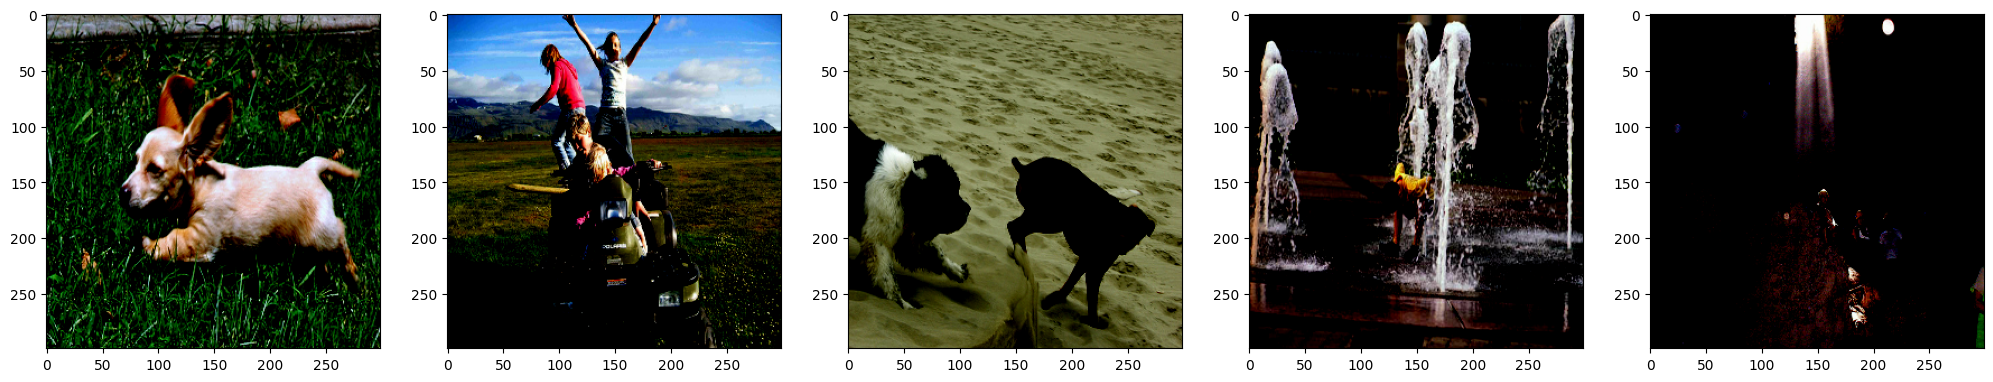

In [22]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

def process_images(imgs):
    img= tf.io.read_file(imgs)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,(299,299))
    img = preprocess_input(img)
    return img , imgs

figure , axes = plt.subplots(1,5)
figure.set_figwidth(25)
for i , ax in zip(range(5),axes):
    rand = random.randrange(20,600,5)
    img  = all_imgs_path[rand]
    img , img_path = process_images(img)
    ax.imshow(img);

# Dataset Creation

In [23]:
unique_list = sorted(set(all_imgs_path))
Imgs_Dataset = tf.data.Dataset.from_tensor_slices(unique_list)
Imgs_Dataset = Imgs_Dataset.map(process_images,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64,drop_remainder=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AxesImage(shape=(299, 299, 3))


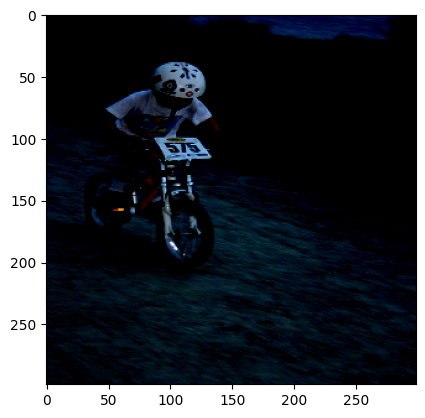

In [24]:
# now this will return a batch of 64 images in each batch , which will reduce memory while trainig
for i in Imgs_Dataset.take(1):
    # print(plt.imshow(i))
    print(plt.imshow(i[0][55].numpy()))

In [25]:
for batch in Imgs_Dataset.take(1):
    print(f"Batch shape :{batch[0].shape}")
    print(f"Image in Batch shape :{batch[0][0].shape}")
    print(f"Image Path Batch shape :{batch[1].shape}")

Batch shape :(64, 299, 299, 3)
Image in Batch shape :(299, 299, 3)
Image Path Batch shape :(64,)


In [26]:
path_train , path_test , cap_train , cap_test = train_test_split(all_imgs_path , all_captions_padded,test_size=0.2 \
                                                                , random_state=43)

In [27]:
print(f"Len of train paths {len(path_train)}")
print(f"Len of test paths {len(path_test)}")
print(f"Len of captrain {len(cap_train)}")
print(f"Len of capttest {len(cap_test)}")

Len of train paths 32364
Len of test paths 8091
Len of captrain 32364
Len of capttest 8091


In [28]:
image_model = InceptionV3(include_top=False , weights= "imagenet")
image_input_layer = image_model.input
image_last_layer = image_model.layers[-1].output

image_model = tf.keras.models.Model(image_input_layer , image_last_layer)

In [29]:
img_features = {}
for image , imagepath in tqdm(Imgs_Dataset):
    print(f"This is the batch , {image.shape}")
    
    batch_features = image_model(image)
    
    batch_features_flattened = tf.reshape(batch_features ,
                                          (batch_features.shape[0] , -1 
                                           , batch_features.shape[3])) # batch (64 , 8,8, 2048) ==> (64, 8*8 , 2048)
    
    for x ,y in zip(batch_features_flattened , imagepath):
        feature_path = y.numpy().decode("utf-8")
        img_features[feature_path] = x.numpy()
        

  0%|          | 0/127 [00:00<?, ?it/s]

This is the batch , (64, 299, 299, 3)


  1%|          | 1/127 [00:09<19:25,  9.25s/it]

This is the batch , (64, 299, 299, 3)


  2%|▏         | 2/127 [00:09<08:23,  4.03s/it]

This is the batch , (64, 299, 299, 3)


  2%|▏         | 3/127 [00:09<04:52,  2.36s/it]

This is the batch , (64, 299, 299, 3)


  3%|▎         | 4/127 [00:10<03:12,  1.57s/it]

This is the batch , (64, 299, 299, 3)


  4%|▍         | 5/127 [00:10<02:18,  1.13s/it]

This is the batch , (64, 299, 299, 3)


  5%|▍         | 6/127 [00:11<01:45,  1.15it/s]

This is the batch , (64, 299, 299, 3)


  6%|▌         | 7/127 [00:11<01:24,  1.41it/s]

This is the batch , (64, 299, 299, 3)


  6%|▋         | 8/127 [00:11<01:10,  1.68it/s]

This is the batch , (64, 299, 299, 3)


  7%|▋         | 9/127 [00:12<01:02,  1.88it/s]

This is the batch , (64, 299, 299, 3)


  8%|▊         | 10/127 [00:12<00:56,  2.09it/s]

This is the batch , (64, 299, 299, 3)


  9%|▊         | 11/127 [00:12<00:51,  2.27it/s]

This is the batch , (64, 299, 299, 3)


  9%|▉         | 12/127 [00:13<00:48,  2.39it/s]

This is the batch , (64, 299, 299, 3)


 10%|█         | 13/127 [00:13<00:46,  2.45it/s]

This is the batch , (64, 299, 299, 3)


 11%|█         | 14/127 [00:14<00:44,  2.54it/s]

This is the batch , (64, 299, 299, 3)


 12%|█▏        | 15/127 [00:14<00:43,  2.57it/s]

This is the batch , (64, 299, 299, 3)


 13%|█▎        | 16/127 [00:14<00:43,  2.56it/s]

This is the batch , (64, 299, 299, 3)


 13%|█▎        | 17/127 [00:15<00:41,  2.64it/s]

This is the batch , (64, 299, 299, 3)


 14%|█▍        | 18/127 [00:15<00:41,  2.65it/s]

This is the batch , (64, 299, 299, 3)


 15%|█▍        | 19/127 [00:15<00:40,  2.65it/s]

This is the batch , (64, 299, 299, 3)


 16%|█▌        | 20/127 [00:16<00:40,  2.67it/s]

This is the batch , (64, 299, 299, 3)


 17%|█▋        | 21/127 [00:16<00:40,  2.63it/s]

This is the batch , (64, 299, 299, 3)


 17%|█▋        | 22/127 [00:17<00:39,  2.65it/s]

This is the batch , (64, 299, 299, 3)


 18%|█▊        | 23/127 [00:17<00:39,  2.60it/s]

This is the batch , (64, 299, 299, 3)


 19%|█▉        | 24/127 [00:17<00:39,  2.62it/s]

This is the batch , (64, 299, 299, 3)


 20%|█▉        | 25/127 [00:18<00:38,  2.65it/s]

This is the batch , (64, 299, 299, 3)


 20%|██        | 26/127 [00:18<00:37,  2.66it/s]

This is the batch , (64, 299, 299, 3)


 21%|██▏       | 27/127 [00:18<00:38,  2.60it/s]

This is the batch , (64, 299, 299, 3)


 22%|██▏       | 28/127 [00:19<00:37,  2.62it/s]

This is the batch , (64, 299, 299, 3)


 23%|██▎       | 29/127 [00:19<00:37,  2.64it/s]

This is the batch , (64, 299, 299, 3)


 24%|██▎       | 30/127 [00:20<00:37,  2.56it/s]

This is the batch , (64, 299, 299, 3)


 24%|██▍       | 31/127 [00:20<00:38,  2.51it/s]

This is the batch , (64, 299, 299, 3)


 25%|██▌       | 32/127 [00:20<00:38,  2.47it/s]

This is the batch , (64, 299, 299, 3)


 26%|██▌       | 33/127 [00:21<00:38,  2.42it/s]

This is the batch , (64, 299, 299, 3)


 27%|██▋       | 34/127 [00:21<00:38,  2.40it/s]

This is the batch , (64, 299, 299, 3)


 28%|██▊       | 35/127 [00:22<00:39,  2.36it/s]

This is the batch , (64, 299, 299, 3)


 28%|██▊       | 36/127 [00:22<00:39,  2.28it/s]

This is the batch , (64, 299, 299, 3)


 29%|██▉       | 37/127 [00:23<00:38,  2.32it/s]

This is the batch , (64, 299, 299, 3)


 30%|██▉       | 38/127 [00:23<00:38,  2.34it/s]

This is the batch , (64, 299, 299, 3)


 31%|███       | 39/127 [00:23<00:37,  2.34it/s]

This is the batch , (64, 299, 299, 3)


 31%|███▏      | 40/127 [00:24<00:37,  2.31it/s]

This is the batch , (64, 299, 299, 3)


 32%|███▏      | 41/127 [00:24<00:37,  2.30it/s]

This is the batch , (64, 299, 299, 3)


 33%|███▎      | 42/127 [00:25<00:36,  2.30it/s]

This is the batch , (64, 299, 299, 3)


 34%|███▍      | 43/127 [00:25<00:36,  2.30it/s]

This is the batch , (64, 299, 299, 3)


 35%|███▍      | 44/127 [00:26<00:35,  2.33it/s]

This is the batch , (64, 299, 299, 3)


 35%|███▌      | 45/127 [00:26<00:35,  2.34it/s]

This is the batch , (64, 299, 299, 3)


 36%|███▌      | 46/127 [00:26<00:34,  2.37it/s]

This is the batch , (64, 299, 299, 3)


 37%|███▋      | 47/127 [00:27<00:33,  2.37it/s]

This is the batch , (64, 299, 299, 3)


 38%|███▊      | 48/127 [00:27<00:33,  2.33it/s]

This is the batch , (64, 299, 299, 3)


 39%|███▊      | 49/127 [00:28<00:33,  2.34it/s]

This is the batch , (64, 299, 299, 3)


 39%|███▉      | 50/127 [00:28<00:32,  2.36it/s]

This is the batch , (64, 299, 299, 3)


 40%|████      | 51/127 [00:29<00:31,  2.39it/s]

This is the batch , (64, 299, 299, 3)


 41%|████      | 52/127 [00:29<00:31,  2.35it/s]

This is the batch , (64, 299, 299, 3)


 42%|████▏     | 53/127 [00:29<00:32,  2.30it/s]

This is the batch , (64, 299, 299, 3)


 43%|████▎     | 54/127 [00:30<00:32,  2.27it/s]

This is the batch , (64, 299, 299, 3)


 43%|████▎     | 55/127 [00:30<00:32,  2.25it/s]

This is the batch , (64, 299, 299, 3)


 44%|████▍     | 56/127 [00:31<00:32,  2.20it/s]

This is the batch , (64, 299, 299, 3)


 45%|████▍     | 57/127 [00:31<00:32,  2.15it/s]

This is the batch , (64, 299, 299, 3)


 46%|████▌     | 58/127 [00:32<00:33,  2.06it/s]

This is the batch , (64, 299, 299, 3)


 46%|████▋     | 59/127 [00:32<00:32,  2.08it/s]

This is the batch , (64, 299, 299, 3)


 47%|████▋     | 60/127 [00:33<00:31,  2.10it/s]

This is the batch , (64, 299, 299, 3)


 48%|████▊     | 61/127 [00:33<00:32,  2.06it/s]

This is the batch , (64, 299, 299, 3)


 49%|████▉     | 62/127 [00:34<00:31,  2.07it/s]

This is the batch , (64, 299, 299, 3)


 50%|████▉     | 63/127 [00:34<00:31,  2.04it/s]

This is the batch , (64, 299, 299, 3)


 50%|█████     | 64/127 [00:35<00:29,  2.13it/s]

This is the batch , (64, 299, 299, 3)


 51%|█████     | 65/127 [00:35<00:28,  2.21it/s]

This is the batch , (64, 299, 299, 3)


 52%|█████▏    | 66/127 [00:36<00:28,  2.16it/s]

This is the batch , (64, 299, 299, 3)


 53%|█████▎    | 67/127 [00:36<00:27,  2.17it/s]

This is the batch , (64, 299, 299, 3)


 54%|█████▎    | 68/127 [00:37<00:27,  2.12it/s]

This is the batch , (64, 299, 299, 3)


 54%|█████▍    | 69/127 [00:37<00:27,  2.09it/s]

This is the batch , (64, 299, 299, 3)


 55%|█████▌    | 70/127 [00:38<00:28,  2.03it/s]

This is the batch , (64, 299, 299, 3)


 56%|█████▌    | 71/127 [00:38<00:28,  1.99it/s]

This is the batch , (64, 299, 299, 3)


 57%|█████▋    | 72/127 [00:39<00:28,  1.94it/s]

This is the batch , (64, 299, 299, 3)


 57%|█████▋    | 73/127 [00:39<00:27,  1.98it/s]

This is the batch , (64, 299, 299, 3)


 58%|█████▊    | 74/127 [00:40<00:26,  2.01it/s]

This is the batch , (64, 299, 299, 3)


 59%|█████▉    | 75/127 [00:40<00:25,  2.00it/s]

This is the batch , (64, 299, 299, 3)


 60%|█████▉    | 76/127 [00:41<00:24,  2.07it/s]

This is the batch , (64, 299, 299, 3)


 61%|██████    | 77/127 [00:41<00:24,  2.08it/s]

This is the batch , (64, 299, 299, 3)


 61%|██████▏   | 78/127 [00:42<00:23,  2.08it/s]

This is the batch , (64, 299, 299, 3)


 62%|██████▏   | 79/127 [00:42<00:22,  2.15it/s]

This is the batch , (64, 299, 299, 3)


 63%|██████▎   | 80/127 [00:42<00:21,  2.20it/s]

This is the batch , (64, 299, 299, 3)


 64%|██████▍   | 81/127 [00:43<00:21,  2.14it/s]

This is the batch , (64, 299, 299, 3)


 65%|██████▍   | 82/127 [00:43<00:20,  2.16it/s]

This is the batch , (64, 299, 299, 3)


 65%|██████▌   | 83/127 [00:44<00:20,  2.18it/s]

This is the batch , (64, 299, 299, 3)


 66%|██████▌   | 84/127 [00:44<00:19,  2.21it/s]

This is the batch , (64, 299, 299, 3)


 67%|██████▋   | 85/127 [00:45<00:18,  2.25it/s]

This is the batch , (64, 299, 299, 3)


 68%|██████▊   | 86/127 [00:45<00:18,  2.27it/s]

This is the batch , (64, 299, 299, 3)


 69%|██████▊   | 87/127 [00:46<00:18,  2.21it/s]

This is the batch , (64, 299, 299, 3)


 69%|██████▉   | 88/127 [00:46<00:17,  2.22it/s]

This is the batch , (64, 299, 299, 3)


 70%|███████   | 89/127 [00:46<00:16,  2.27it/s]

This is the batch , (64, 299, 299, 3)


 71%|███████   | 90/127 [00:47<00:16,  2.30it/s]

This is the batch , (64, 299, 299, 3)


 72%|███████▏  | 91/127 [00:47<00:16,  2.25it/s]

This is the batch , (64, 299, 299, 3)


 72%|███████▏  | 92/127 [00:48<00:15,  2.23it/s]

This is the batch , (64, 299, 299, 3)


 73%|███████▎  | 93/127 [00:48<00:15,  2.13it/s]

This is the batch , (64, 299, 299, 3)


 74%|███████▍  | 94/127 [00:49<00:14,  2.20it/s]

This is the batch , (64, 299, 299, 3)


 75%|███████▍  | 95/127 [00:49<00:14,  2.24it/s]

This is the batch , (64, 299, 299, 3)


 76%|███████▌  | 96/127 [00:50<00:13,  2.26it/s]

This is the batch , (64, 299, 299, 3)


 76%|███████▋  | 97/127 [00:50<00:13,  2.24it/s]

This is the batch , (64, 299, 299, 3)


 77%|███████▋  | 98/127 [00:50<00:12,  2.27it/s]

This is the batch , (64, 299, 299, 3)


 78%|███████▊  | 99/127 [00:51<00:12,  2.28it/s]

This is the batch , (64, 299, 299, 3)


 79%|███████▊  | 100/127 [00:51<00:11,  2.28it/s]

This is the batch , (64, 299, 299, 3)


 80%|███████▉  | 101/127 [00:52<00:11,  2.22it/s]

This is the batch , (64, 299, 299, 3)


 80%|████████  | 102/127 [00:52<00:11,  2.24it/s]

This is the batch , (64, 299, 299, 3)


 81%|████████  | 103/127 [00:53<00:10,  2.27it/s]

This is the batch , (64, 299, 299, 3)


 82%|████████▏ | 104/127 [00:53<00:10,  2.29it/s]

This is the batch , (64, 299, 299, 3)


 83%|████████▎ | 105/127 [00:54<00:09,  2.30it/s]

This is the batch , (64, 299, 299, 3)


 83%|████████▎ | 106/127 [00:54<00:09,  2.30it/s]

This is the batch , (64, 299, 299, 3)


 84%|████████▍ | 107/127 [00:54<00:08,  2.33it/s]

This is the batch , (64, 299, 299, 3)


 85%|████████▌ | 108/127 [00:55<00:08,  2.32it/s]

This is the batch , (64, 299, 299, 3)


 86%|████████▌ | 109/127 [00:55<00:07,  2.30it/s]

This is the batch , (64, 299, 299, 3)


 87%|████████▋ | 110/127 [00:56<00:07,  2.24it/s]

This is the batch , (64, 299, 299, 3)


 87%|████████▋ | 111/127 [00:56<00:07,  2.24it/s]

This is the batch , (64, 299, 299, 3)


 88%|████████▊ | 112/127 [00:57<00:06,  2.27it/s]

This is the batch , (64, 299, 299, 3)


 89%|████████▉ | 113/127 [00:57<00:06,  2.27it/s]

This is the batch , (64, 299, 299, 3)


 90%|████████▉ | 114/127 [00:58<00:05,  2.20it/s]

This is the batch , (64, 299, 299, 3)


 91%|█████████ | 115/127 [00:58<00:05,  2.21it/s]

This is the batch , (64, 299, 299, 3)


 91%|█████████▏| 116/127 [00:58<00:04,  2.23it/s]

This is the batch , (64, 299, 299, 3)


 92%|█████████▏| 117/127 [00:59<00:04,  2.22it/s]

This is the batch , (64, 299, 299, 3)


 93%|█████████▎| 118/127 [00:59<00:04,  2.16it/s]

This is the batch , (64, 299, 299, 3)


 94%|█████████▎| 119/127 [01:00<00:04,  2.00it/s]

This is the batch , (64, 299, 299, 3)


 94%|█████████▍| 120/127 [01:01<00:03,  1.92it/s]

This is the batch , (64, 299, 299, 3)


 95%|█████████▌| 121/127 [01:01<00:03,  1.82it/s]

This is the batch , (64, 299, 299, 3)


 96%|█████████▌| 122/127 [01:02<00:02,  1.86it/s]

This is the batch , (64, 299, 299, 3)


 97%|█████████▋| 123/127 [01:02<00:02,  1.90it/s]

This is the batch , (64, 299, 299, 3)


 98%|█████████▊| 124/127 [01:03<00:01,  1.98it/s]

This is the batch , (64, 299, 299, 3)


 98%|█████████▊| 125/127 [01:03<00:00,  2.07it/s]

This is the batch , (64, 299, 299, 3)


 99%|█████████▉| 126/127 [01:04<00:00,  2.14it/s]

This is the batch , (27, 299, 299, 3)


100%|██████████| 127/127 [01:05<00:00,  1.93it/s]


In [30]:
img_features.keys()

dict_keys(['flickr8k/Images/1000268201_693b08cb0e.jpg', 'flickr8k/Images/1001773457_577c3a7d70.jpg', 'flickr8k/Images/1002674143_1b742ab4b8.jpg', 'flickr8k/Images/1003163366_44323f5815.jpg', 'flickr8k/Images/1007129816_e794419615.jpg', 'flickr8k/Images/1007320043_627395c3d8.jpg', 'flickr8k/Images/1009434119_febe49276a.jpg', 'flickr8k/Images/1012212859_01547e3f17.jpg', 'flickr8k/Images/1015118661_980735411b.jpg', 'flickr8k/Images/1015584366_dfcec3c85a.jpg', 'flickr8k/Images/101654506_8eb26cfb60.jpg', 'flickr8k/Images/101669240_b2d3e7f17b.jpg', 'flickr8k/Images/1016887272_03199f49c4.jpg', 'flickr8k/Images/1019077836_6fc9b15408.jpg', 'flickr8k/Images/1019604187_d087bf9a5f.jpg', 'flickr8k/Images/1020651753_06077ec457.jpg', 'flickr8k/Images/1022454332_6af2c1449a.jpg', 'flickr8k/Images/1022454428_b6b660a67b.jpg', 'flickr8k/Images/1022975728_75515238d8.jpg', 'flickr8k/Images/102351840_323e3de834.jpg', 'flickr8k/Images/1024138940_f1fefbdce1.jpg', 'flickr8k/Images/102455176_5f8ead62d5.jpg', 'fl

In [31]:
def map(image_name , caption):
    image_feature = img_features[image_name.decode("utf-8")]
    return image_feature , caption

In [32]:
def gen_dataset(img_paths , caps):
    # This return pairs of image feature alongaside with the caption 
    # output should be like this ==> (image_feature 1,caption1 ) , (image_feature 1, caption2)
    data = tf.data.Dataset.from_tensor_slices((img_paths , caps))

    data = data.map(lambda ele1 , ele2 : tf.numpy_function(map ,[ele1 , ele2] , [tf.float32 , tf.int32]) , 
                    num_parallel_calls= tf.data.experimental.AUTOTUNE)
    data = data.shuffle(buffer_size=1000, reshuffle_each_iteration= True).batch(64, drop_remainder = False) \
    .prefetch(tf.data.experimental.AUTOTUNE)

    return data    
    

In [33]:
train_dataset = gen_dataset(path_train , cap_train)
test_dataset = gen_dataset(path_test , cap_test)

In [34]:
for i in train_dataset.take(1):
    print(i[0].numpy().shape)
    print(i[1].numpy().shape)

(64, 64, 2048)
(64, 31)


# Model Building

In [35]:
BATCH_SIZE = 64
units = 512
embedding_dim = 256
vocab_size = 5001

train_num_steps = len(path_train) // BATCH_SIZE 
test_num_steps = len(path_test) // BATCH_SIZE  
max_length = 31

In [36]:
class Encoder (tf.keras.models.Model):
    def __init__(self,embed_dim):
        super(Encoder,self).__init__()
        self.dense = Dense(embed_dim , activation="relu")
    
    def call(self,features):
        features = self.dense(features)

        return features
        

In [37]:
encoder = Encoder(embedding_dim)

In [38]:
class Attention(tf.keras.models.Model):
    def __init__(self , units):
        super(Attention,self).__init__()
        self.W = Dense(units)
        self.K = Dense(units)
        self.V = Dense(1)
        self.units = units
    
    def call(self,features , hidden):
        # print("start attention")
        # print(f"hidden shape before {hidden.shape}")
        hidden = hidden[: , tf.newaxis]
        # print(f"hidden shape after {hidden.shape}")

        # print(f"W1 : {self.W(features).shape}")
        # print(f"K : {self.K(hidden).shape}")
        # print(f"concatenation {self.W(features) + self.K(hidden)}")
        score = tf.keras.activations.tanh(self.W(features) + self.K(hidden))
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        # print(f"context vector :f{context_vector.shape}")
        return context_vector, attention_weights

In [63]:
class Decoder(tf.keras.models.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention(self.units) 
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) 
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) 
        self.d2 = tf.keras.layers.Dense(vocab_size) 

    def call(self,x,features,hidden):
        # print("start decoder")
        context_vector, attention_weights = self.attention(features, hidden)
        # print("end attention")
        embed = self.embed(x)
        # print(f"embedding dim {embed.shape}")
        # print(f"context vector expanded : {tf.expand_dims(context_vector, 1).shape}")
        # print(f"concatenated vector expanded : {tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1)}")
        # print("start concat")
        context_vector_expanded = tf.expand_dims(context_vector, 1)
        context_vector_broadcasted = tf.broadcast_to(context_vector_expanded, tf.shape(embed))
        conct = tf.concat([context_vector_broadcasted, embed], axis=-1) 
        # print("end concat")

        output , state = self.gru(conct)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output)
        # print("end decoder")
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))        

In [64]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001) 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) 

In [63]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# Training and Testing

In [64]:
image_sample , caption_sample = next(iter(train_dataset))

In [65]:
print(f"{image_sample.shape}")
print(f"{caption_sample.shape}")

(64, 64, 2048)
(64, 31)


In [66]:
hidden_temp = decoder.init_state(64)
print(f"{hidden_temp.shape}")

(64, 512)


In [67]:
img_sample_encoder  = encoder(image_sample)
img_sample_encoder.shape

TensorShape([64, 64, 256])

In [69]:
dec_input = tf.expand_dims([tokenizer.word_index["<sos>"]] * caption_sample.shape[0] , 1)
dec_input.shape

TensorShape([64, 1])

In [70]:
output , state , attention_weights = decoder(dec_input,img_sample_encoder , hidden_temp)

In [72]:
print(f"output shape : {tokenizer.index_word[np.argmax(output[0].shape)]}")
print(f"output shape : {state.shape}")
print(f"output shape : {attention_weights.shape}")
print(f"output shape : {attention_weights.shape}")

output shape : PAD
output shape : (64, 512)
output shape : (64, 64, 1)
output shape : (64, 64, 1)


In [73]:
@tf.function
def train_step(img , target):
    hidden = decoder.init_state(img.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index["<sos>"]] * target.shape[0] , 1)
    loss = 0
    with tf.GradientTape() as tape :
        features = encoder(img)
        for r in range(1,target.shape[1]):
            output , hidden , attention_weights = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,r],output)
            dec_input = tf.expand_dims(target[:,r],1)  # teacher forcing is applied here

    avg_loss = (loss / int(target.shape[1]))
    all_trainable_params = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss , all_trainable_params)
    optimizer.apply_gradients(zip(grads,all_trainable_params))

    return loss , avg_loss

In [74]:
@tf.function
def test_step(img, target):
    hidden = decoder.init_state(img.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index["<sos>"]] * target.shape[0] , 1)
    loss = 0
    with tf.GradientTape() as tape :
        features = encoder(img)
        for r in range(1,target.shape[1]):
            output , hidden , attention_weights = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,r],output)
            dec_input = tf.expand_dims(target[:,r],1)  # teacher forcing is applied here

    avg_loss = (loss / int(target.shape[1]))
    all_trainable_params = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss , all_trainable_params)
    optimizer.apply_gradients(zip(grads,all_trainable_params))

    return loss , avg_loss

In [75]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [76]:
checkpoint_path = "Checkpoints/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [77]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [78]:
loss_plot = []
test_loss_plot = []
EPOCHS = 20
best_test_loss = 100
for epoch in tqdm(range(0,EPOCHS)):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss+=t_loss
        avg_train_loss = total_loss / train_num_steps
    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    if test_loss < best_test_loss:
        print(f"loss reduced from {best_test_loss} to : {test_loss}")
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/20 [00:00<?, ?it/s]

loss reduced from 100 to : 1.1045300960540771


  5%|▌         | 1/20 [03:39<1:09:30, 219.50s/it]

loss reduced from 1.1045300960540771 to : 0.9642698168754578


 10%|█         | 2/20 [05:24<45:33, 151.87s/it]  

loss reduced from 0.9642698168754578 to : 0.8821128010749817


 15%|█▌        | 3/20 [07:17<38:06, 134.49s/it]

loss reduced from 0.8821128010749817 to : 0.8209491968154907


 20%|██        | 4/20 [09:17<34:17, 128.58s/it]

loss reduced from 0.8209491968154907 to : 0.7715010643005371


 25%|██▌       | 5/20 [11:19<31:35, 126.38s/it]

loss reduced from 0.7715010643005371 to : 0.7266494035720825


 30%|███       | 6/20 [13:25<29:27, 126.25s/it]

loss reduced from 0.7266494035720825 to : 0.6841444373130798


 35%|███▌      | 7/20 [15:31<27:17, 125.98s/it]

loss reduced from 0.6841444373130798 to : 0.6469845771789551


 40%|████      | 8/20 [17:38<25:16, 126.40s/it]

loss reduced from 0.6469845771789551 to : 0.6113481521606445


 45%|████▌     | 9/20 [19:45<23:13, 126.64s/it]

loss reduced from 0.6113481521606445 to : 0.5818399786949158


 50%|█████     | 10/20 [21:53<21:09, 126.96s/it]

loss reduced from 0.5818399786949158 to : 0.5511298179626465


 55%|█████▌    | 11/20 [24:00<19:04, 127.12s/it]

loss reduced from 0.5511298179626465 to : 0.5230951309204102


 60%|██████    | 12/20 [26:08<16:59, 127.38s/it]

loss reduced from 0.5230951309204102 to : 0.49733632802963257


 65%|██████▌   | 13/20 [28:17<14:54, 127.77s/it]

loss reduced from 0.49733632802963257 to : 0.47456637024879456


 70%|███████   | 14/20 [30:25<12:46, 127.74s/it]

loss reduced from 0.47456637024879456 to : 0.45273691415786743


 75%|███████▌  | 15/20 [32:34<10:41, 128.32s/it]

loss reduced from 0.45273691415786743 to : 0.4313775300979614


 80%|████████  | 16/20 [34:49<08:40, 130.22s/it]

loss reduced from 0.4313775300979614 to : 0.41466671228408813


 85%|████████▌ | 17/20 [37:16<06:45, 135.13s/it]

loss reduced from 0.41466671228408813 to : 0.39785775542259216


 90%|█████████ | 18/20 [39:35<04:33, 136.56s/it]

loss reduced from 0.39785775542259216 to : 0.38230153918266296


 95%|█████████▌| 19/20 [41:49<02:15, 135.64s/it]

loss reduced from 0.38230153918266296 to : 0.36882030963897705


100%|██████████| 20/20 [44:06<00:00, 132.33s/it]


In [75]:
attention_shape = x.shape[0]

In [195]:
def decode_sequence(img_test , temperature=1.0):
    image_read = process_images(img_test)[0]
    image_expanded = tf.expand_dims(image_read, 0) #add batch dimension
    img_fet = image_model(image_expanded) 
    img_fet = tf.reshape(img_fet, (img_fet.shape[0], -1, img_fet.shape[3]))

    attention_plot = np.zeros((max_length , attention_shape))
    
    encoded_image = encoder(img_fet)
    hidden_temp = decoder.init_state(batch_size=1)
    dec_input = [tokenizer.word_index["<sos>"]]
    dec_input = tf.expand_dims(dec_input,0)
    result = []
    for i in range(max_length):
        output , hidden_temp , attention_weights = decoder(dec_input,encoded_image,hidden_temp)
        
        output /= temperature
        if temperature ==1.0:
            predicted_token = tf.argmax(output[0]).numpy()
        else:
            predicted_token = tf.random.categorical(output, num_samples=1)[0, 0].numpy()
        result.append(tokenizer.index_word[predicted_token])

        attention_plot[i] = tf.reshape(attention_weights , (-1,)).numpy()

        if tokenizer.index_word[predicted_token] == '<end>':
            return result,output
        
        dec_input = tf.expand_dims([predicted_token],0)
    attention_plot = attention_plot[:len(result) , :]  #getting the plot without the max length 
    return result , output , attention_plot


In [113]:
def postprocess_text(predicted_cap):
    filt = ["PAD","<sos>","<unk>","<eos>","UNK"]
    processed = []
    for word in predicted_cap:
        if word not in filt:
            processed.append(word)
    return " ".join(processed)

In [109]:
result , output ,attention_plot= decode_sequence(path_test[55])

In [110]:
generated_cap = postprocess_text(result)
print(generated_cap)

man stands on mat in front of crowd


In [111]:
def real_cap(cap):
    real_cap = []
    for token in cap:
        real_cap.append(tokenizer.index_word[token])
    real_cap = postprocess_text(real_cap)
    return real_cap

original_cap = real_cap(cap_test[55])
print(original_cap)

the guy in the black jacket is standing on his hand on checkered UNK


C:\Users\DELL\AppData\Local\Temp\ipykernel_1792\1797776409.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread(path_test[55]))


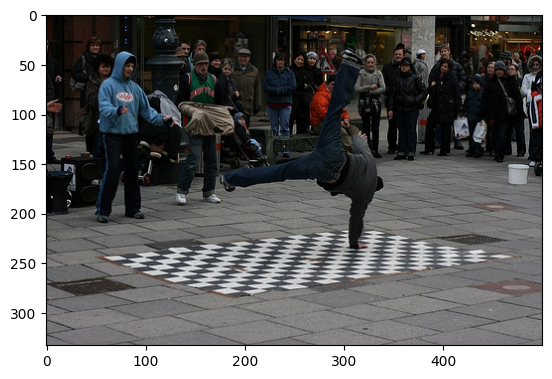

In [112]:
plt.imshow(imageio.imread(path_test[55]))

In [143]:
decoder.save_weights("Models/decoder.h5")
encoder.save_weights("Models/encoder.h5")

In [61]:
encoder.save("Models/encoder_model")

INFO:tensorflow:Assets written to: Models/encoder_model\assets


In [73]:
decoder.save("Models/decoder_model")

INFO:tensorflow:Assets written to: Models/decoder_model\assets


INFO:tensorflow:Assets written to: Models/decoder_model\assets


In [60]:
import pickle 
with open("Models/tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer,file)

## Loading Weights

In [8]:
encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim,units,vocab_size)

In [69]:
encoder.load_weights('Models/encoder.h5')
decoder.load_weights('Models/decoder.h5')

## Putting all together

In [197]:
def show_all(idx,temperature=1.0):
    i = Image.open(path_test[idx])
    i = i.resize((224,224))
    result , output ,attention_plot= decode_sequence(path_test[idx],temperature=temperature)
    generated_cap = postprocess_text(result)
    original_cap = real_cap(cap_test[idx])
    fig , ax = plt.subplots()
    fig.set_figwidth(20)
    
    ax.imshow(i)
    all = [f"Original : \n \n {original_cap}" , f"Generated : \n\n {generated_cap}"]
    all = ("\n" * 2).join(all)
    ax.text( 250 , 150 ,s=all , fontsize=20)
    ax.set_axis_off()

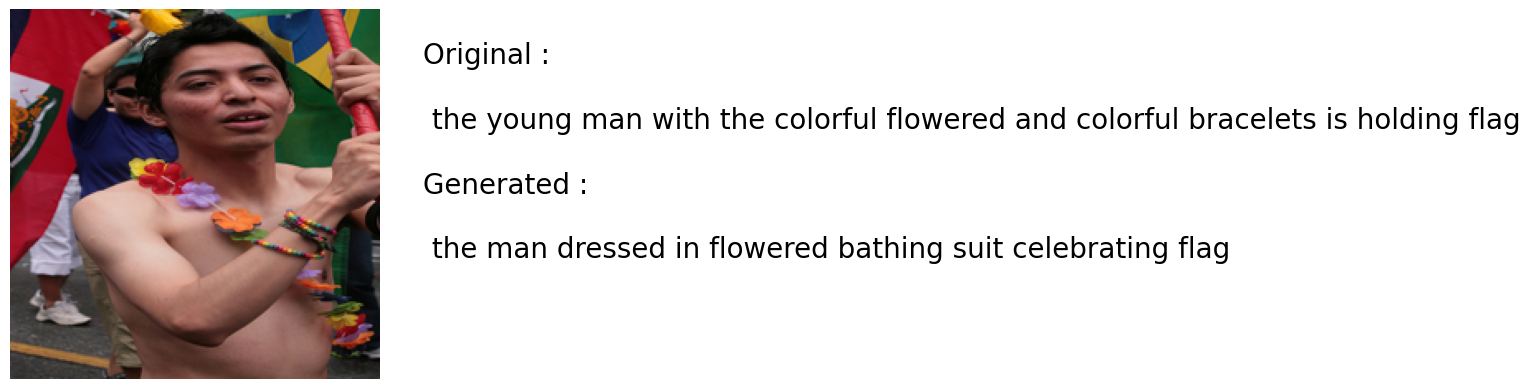

In [203]:
show_all(42,0.3)